<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/train_validation_test_split/train_test_split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
SAMPLE_CSV_PATH = "/MyDrive/amazon_rainforest_files/amazon_sample_data/2023_06_23_Results_Google.csv" #@param
FEATURE_COLUMNS = ["Code", "Origin", "lat", "long", "VPD", "RH", "PET", "DEM", "PA"] #@param
LABEL_COLUMNS = ["d18O_cel"] #@param

# The columns that will be used to group the dataset to calculate
# means and variance on LABEL_COLUMNS
GROUPING_COLUMNS = ["Code"] #@param
# If True, the rows will remain unique GROUPING_COLUMNS values. Otherwise
# we merge the grouping columns aggregates with the original dataset.
KEEP_GROUPING = True #@param

# Values can be:
# - SORTING: Sample rows are sorted by key made of PARTITION_COLUMNS
PARTITION_STRATEGY = "FIXED" #@param
assert(PARTITION_STRATEGY in ['FIXED'])

# For FIXED only, the bounds of each partition for the split
TRAIN_FIXED_BOUNDS = [(float('-inf'), float('-inf')), (-5, float('inf'))]
VALIDATION_FIXED_BOUNDS = [(-5, float('-inf')), (float('inf'), -62.5)]
TEST_FIXED = BOUNDS = [(-5, -62.5), (float('inf'), float('inf'))]
TRAIN_VALIDATION_TEST_BOUNDS = [TRAIN_FIXED_BOUNDS, VALIDATION_FIXED_BOUNDS, TEST_FIXED]

OUTPUT_TRAIN_CSV_PATH = "/MyDrive/amazon_rainforest_files/amazon_sample_data/luis_train.csv" #@param
OUTPUT_VALIDATION_CSV_PATH = "/MyDrive/amazon_rainforest_files/amazon_sample_data/luis_validation.csv" #@param
OUTPUT_TEST_CSV_PATH = "/MyDrive/amazon_rainforest_files/amazon_sample_data/luis_test.csv" #@param

GDRIVE_BASE = "/content/drive" #@param

In [3]:
# Access data stored on Google Drive
if GDRIVE_BASE:
    from google.colab import drive
    drive.mount(GDRIVE_BASE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pre-Process Sample

In [4]:
def preprocess_sample_data(df, feature_columns, label_columns, aggregate_columns, keep_grouping) -> pd.DataFrame:
  '''
  Given a pd.DataFRame df:
  1. Filters in relevant columns using feature_columns, label_columns
  2. Calculates the mean and variance of each column in label_columns grouping
     by a key made of aggregate_columns
  3. If keep_grouping = True, we export groupings by key aggregate_columns
     otherwise we return the original sample with their matching means/variances.
  '''
  df.dropna(subset=feature_columns + label_columns, inplace=True)
  df = df[feature_columns + label_columns]

  if aggregate_columns:
    grouped = df.groupby(aggregate_columns)

    for col in label_columns:
      means = grouped.mean().reset_index()
      means.rename(columns={col: f"{col}_mean"}, inplace=True)
      means = means[aggregate_columns + [f"{col}_mean"]]

      variances = grouped.var().reset_index()
      variances.rename(columns={col: f"{col}_variance"}, inplace=True)
      variances = variances[aggregate_columns + [f"{col}_variance"]]

      df = pd.merge(df, means, how="inner", left_on=aggregate_columns, right_on=aggregate_columns)
      df = pd.merge(df, variances, how="inner", left_on=aggregate_columns, right_on=aggregate_columns)
      df.drop(columns=[col], inplace=True)

    if keep_grouping:
      # The first entry is the same as all entries in the grouping for the
      # aggregate_columns. Any other column will have different values but
      # we only take the first one.
      df = df.groupby(aggregate_columns).first().reset_index()

  return df

In [5]:
df = pd.read_csv(f"{GDRIVE_BASE}/{SAMPLE_CSV_PATH}", encoding="ISO-8859-1", sep=',')
sample_data = preprocess_sample_data(df, FEATURE_COLUMNS, LABEL_COLUMNS, GROUPING_COLUMNS, KEEP_GROUPING)

<ipython-input-4-29778b688ab8>:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = grouped.mean().reset_index()
<ipython-input-4-29778b688ab8>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  variances = grouped.var().reset_index()


## (Optional) Test preprocess_sample_data

In [6]:

from pandas.util.testing import assert_frame_equal

# Average and variance test
def average_variance_test():
  test_df = pd.DataFrame({
      "lat": [0.0, 0.0, 1.0],
      "long": [3.0, 3.0, 6.0],
      "x": [3.0, 3.0, 3.0],
      "y": [8.0, 0.0, -3.0]}
  )
  feature_columns = ["lat", "long"]
  label_columns = ["x", "y"]
  aggregate_columns = ["lat", "long"]
  keep_grouping=True

  test_sample = preprocess_sample_data(test_df, feature_columns, label_columns, aggregate_columns, keep_grouping)
  expected_df = pd.DataFrame({
      "lat": [0.0, 1.0],
      "long": [3.0, 6.0],
      "x_mean": [3.0, 3.0],
      "x_variance": [0.0, np.nan],
      "y_mean": [4.0, -3.0],
      "y_variance": [32.0, np.nan]
  })
  assert_frame_equal(expected_df, test_sample)

def average_variance_test_no_grouping():
  test_df = pd.DataFrame({
      "lat": [0.0, 0.0, 1.0],
      "long": [3.0, 3.0, 6.0],
      "x": [3.0, 3.0, 3.0],
      "y": [8.0, 0.0, -3.0]}
  )
  feature_columns = ["lat", "long"]
  label_columns = ["x", "y"]
  aggregate_columns = ["lat", "long"]
  keep_grouping=False

  test_sample = preprocess_sample_data(test_df, feature_columns, label_columns, aggregate_columns, keep_grouping)
  expected_df = pd.DataFrame({
      "lat": [0.0, 0.0, 1.0],
      "long": [3.0, 3.0, 6.0],
      "x_mean": [3.0, 3.0, 3.0],
      "x_variance": [0.0, 0.0, np.nan],
      "y_mean": [4.0, 4.0, -3.0],
      "y_variance": [32.0, 32.0, np.nan]
  })
  assert_frame_equal(expected_df, test_sample)

def average_variance_test_keep_nonnumerical_columns():
  test_df = pd.DataFrame({
      "code": ["a", "b", "c"],
      "lat": [0.0, 0.0, 1.0],
      "long": [3.0, 3.0, 6.0],
      "x": [3.0, 3.0, 3.0],
      "y": [8.0, 0.0, -3.0]}
  )
  feature_columns = ["code", "lat", "long"]
  label_columns = ["x", "y"]
  aggregate_columns = ["lat", "long"]
  keep_grouping=True

  test_sample = preprocess_sample_data(test_df, feature_columns, label_columns, aggregate_columns, keep_grouping)
  expected_df = pd.DataFrame({
      "lat": [0.0, 1.0],
      "long": [3.0, 6.0],
      "code": ["a", "c"],
      "x_mean": [3.0, 3.0],
      "x_variance": [0.0, np.nan],
      "y_mean": [4.0, -3.0],
      "y_variance": [32.0, np.nan]
  })
  assert_frame_equal(expected_df, test_sample)

average_variance_test()
average_variance_test_no_grouping()
average_variance_test_keep_nonnumerical_columns()

<ipython-input-6-0abc456ab875>:1: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
<ipython-input-4-29778b688ab8>:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = grouped.mean().reset_index()
<ipython-input-4-29778b688ab8>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  variances = grouped.var().reset_index()


   lat  long code  x_mean  x_variance  y_mean  y_variance
0  0.0   3.0    a     3.0         0.0     4.0        32.0
1  1.0   6.0    c     3.0         NaN    -3.0         NaN


<ipython-input-4-29778b688ab8>:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = grouped.mean().reset_index()
<ipython-input-4-29778b688ab8>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  variances = grouped.var().reset_index()


# Partition Data

In [7]:
def partition_data_fixed(sample_data, train_validation_test_bounds):
  '''
  Return data split between the fixed rectangle train_validation_test_bounds
  of lattitude and longitude for each of the rows in sample_data.
  '''
  train_bounds = train_validation_test_bounds[0]
  validation_bounds = train_validation_test_bounds[1]
  test_bounds = train_validation_test_bounds[2]

  train_data = sample_data[
      (sample_data['lat'] >= train_bounds[0][0]) & (sample_data['long'] >= train_bounds[0][1]) &
      (sample_data['lat'] <= train_bounds[1][0]) & (sample_data['long'] <= train_bounds[1][1])]
  validation_data = sample_data[
      (sample_data['lat'] >= validation_bounds[0][0]) & (sample_data['long'] >= validation_bounds[0][1]) &
      (sample_data['lat'] <= validation_bounds[1][0]) & (sample_data['long'] <= validation_bounds[1][1])]
  test_data = sample_data[
      (sample_data['lat'] >= test_bounds[0][0]) & (sample_data['long'] >= test_bounds[0][1]) &
      (sample_data['lat'] <= test_bounds[1][0]) & (sample_data['long'] <= test_bounds[1][1])]

  return train_data, validation_data, test_data

In [8]:
if PARTITION_STRATEGY == "FIXED":
  train_data, validation_data, test_data = partition_data_fixed(sample_data, TRAIN_VALIDATION_TEST_BOUNDS)
else:
  raise ValueError(f"Unknown partition strategy: {PARTITION_STRATEGY}")

In [9]:
print(train_data.shape[0])
print(validation_data.shape[0])
print(test_data.shape[0])

22
34
69


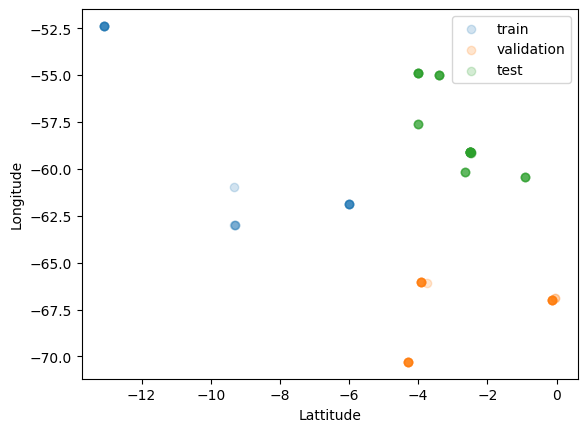

In [10]:
# Optional (plot splits)
import matplotlib
import matplotlib.pyplot as plt

plt.scatter(train_data["lat"], train_data["long"], label="train", alpha=0.2)
plt.scatter(validation_data["lat"], validation_data["long"], label="validation", alpha=0.2)
plt.scatter(test_data["lat"], test_data["long"], label="test", alpha=0.2)
plt.xlabel('Lattitude')
plt.ylabel('Longitude')
plt.legend()
plt.show()

In [11]:
train_data.to_csv(f"{GDRIVE_BASE}{OUTPUT_TRAIN_CSV_PATH}")
validation_data.to_csv(f"{GDRIVE_BASE}{OUTPUT_VALIDATION_CSV_PATH}")
test_data.to_csv(f"{GDRIVE_BASE}{OUTPUT_TEST_CSV_PATH}")

In [12]:
train_data['d18O_cel_mean'].unique()

array([24.042     , 25.24      , 25.782     , 25.076     , 25.966     ,
       27.434     , 28.156     , 26.836     , 28.18      , 26.834     ,
       26.644     , 26.772     , 27.68428   , 27.403235  , 24.77767   ,
       25.55185   , 25.115885  , 25.987815  , 24.13203125, 24.898     ,
       23.944     , 26.018     ])